In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from astropy.time import Time
from scipy.signal import convolve
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import AltAz
from astropy.coordinates import ICRS
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
#Load data
CasA_raw = np.fromfile('AST326_ARO_CasA_calibration.dat')

In [3]:
#Name variables accordint to lab manual
nf = CasA_raw[0].astype(np.int32) #The first number in the array, number of frequency channels
nt = CasA_raw[1].astype(np.int32) #The second number in the array, number of time slices
ns = CasA_raw[2].astype(np.int32) #The third number in the array, size of each time slice
lf = CasA_raw[3:1027] #The fourth number to the length of nf, list of frequencies
lf_flipped = np.flip(lf,axis=0) #Frequencies are in reverse order so flip

In [4]:
#Real data begins after number 1027, all of the rest is header
CasA_data = CasA_raw[1027:]

#Slice the data into the time slices
CasA_slices = CasA_data.reshape(-1, 1027)
timestamp_CasA = CasA_slices[:,0] #In MJD
alt_CasA_ARO = CasA_slices[:,1] #altitude pointing of ARO
az_CasA_ARO = CasA_slices[:,2] #azimuth pointing of ARO
StokesI_CasA_data = CasA_slices[:, 3:1027] #Stokes I samples for each frequency, in order
StokesI_CasA_ARO = np.flip(StokesI_CasA_data, axis=1)

In [5]:
#Convert from AltAz to RADec
ARO_pos = EarthLocation(lat = '45d57m19.8s', lon = '281d55m37s', height = (260.4*u.m))
times = Time(timestamp_CasA, format = 'mjd') #Puts time into correct format
radec_coord = []
for n in range(len(times)):
    current_orient = SkyCoord(alt = alt_CasA_ARO[n]*u.deg, az = az_CasA_ARO[n]*u.deg, frame = 'altaz', obstime = times[n], location = ARO_pos)
    current_orient_radec = current_orient.transform_to('icrs')
    radec_coord.append(current_orient_radec)

In [6]:
#AltAz coordinates
AltAz_CasA_ARO = np.stack((alt_CasA_ARO, az_CasA_ARO), axis=-1)

<SkyCoord (ICRS): (ra, dec) in deg
    (350.85833333, 58.8)>


Text(0.5,0,'Coordinate Offset (Degrees)')

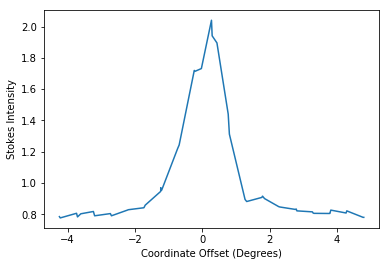

In [7]:
#Plot intensity for each frequency band
Stokes_1 = StokesI_CasA_ARO[:,0]
Stokes_mean1 = np.mean(Stokes_1)
Stokes_sigma1 = np.std(Stokes_1)

CasA = SkyCoord(ra='23h23m26s', dec = '58°48′')
#The Above converts to (ra, dec) in deg (350.85833333, 58.8)>
print(CasA)
offset_list = []
for n in range(len(radec_coord)):
    offset = CasA.separation(radec_coord[n])
    offset_list.append(offset.value)

#Change to not absolute value
offset_neg = np.negative(offset_list[0:22]).tolist()
offset_list_final = offset_list[22:]
for i in range(len(offset_neg)):
    offset_list_final.append(offset_neg[i])
    
offset_sorted = np.sort(offset_list_final)
offset_array = np.array(offset_sorted)

plt.plot(offset_array, Stokes_1)
plt.ylabel('Stokes Intensity')
plt.xlabel('Coordinate Offset (Degrees)')

Text(0,0.5,'Power in Sub-band (arb units)')

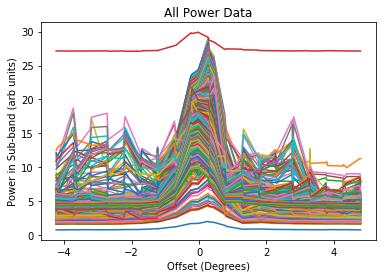

In [8]:
plt.plot(offset_array, StokesI_CasA_ARO)
plt.title('All Power Data')
plt.xlabel('Offset (Degrees)')
plt.ylabel('Power in Sub-band (arb units)')

Text(0,0.5,'Off-Source Power')

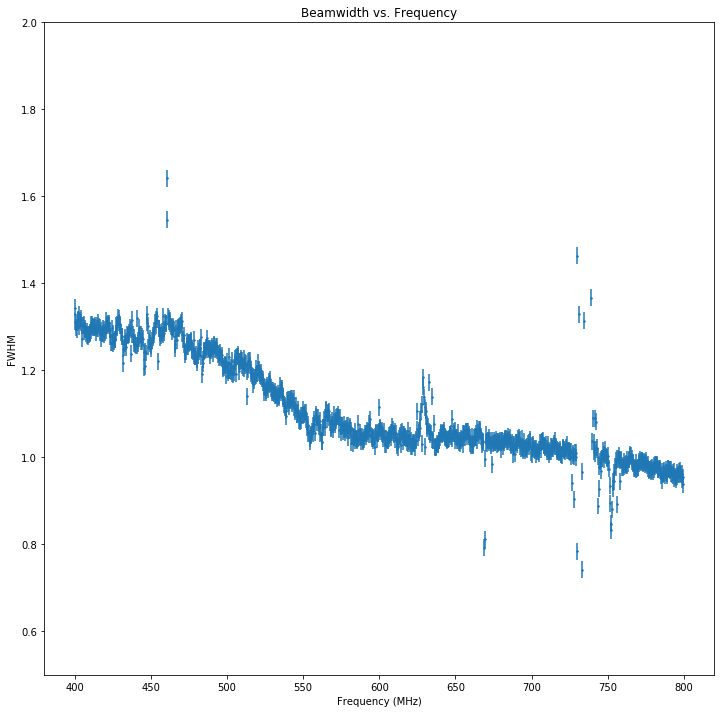

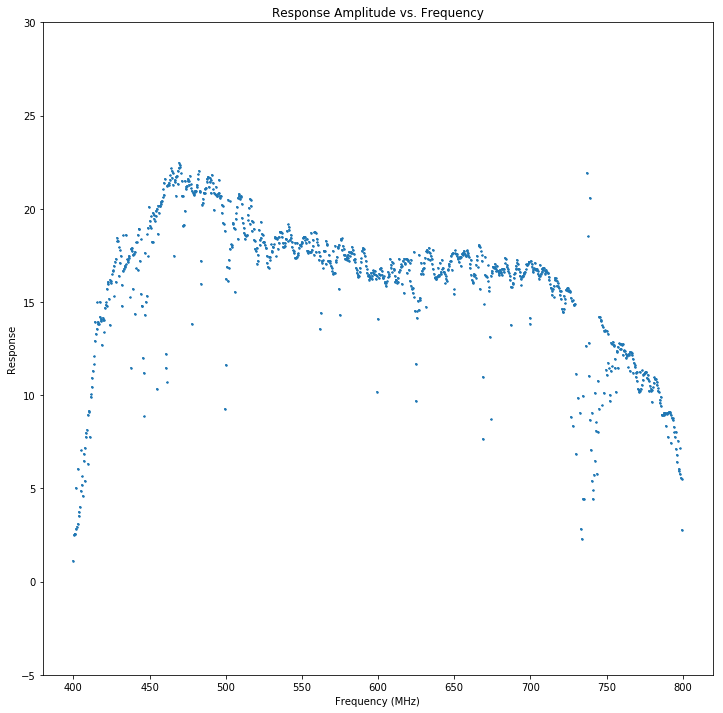

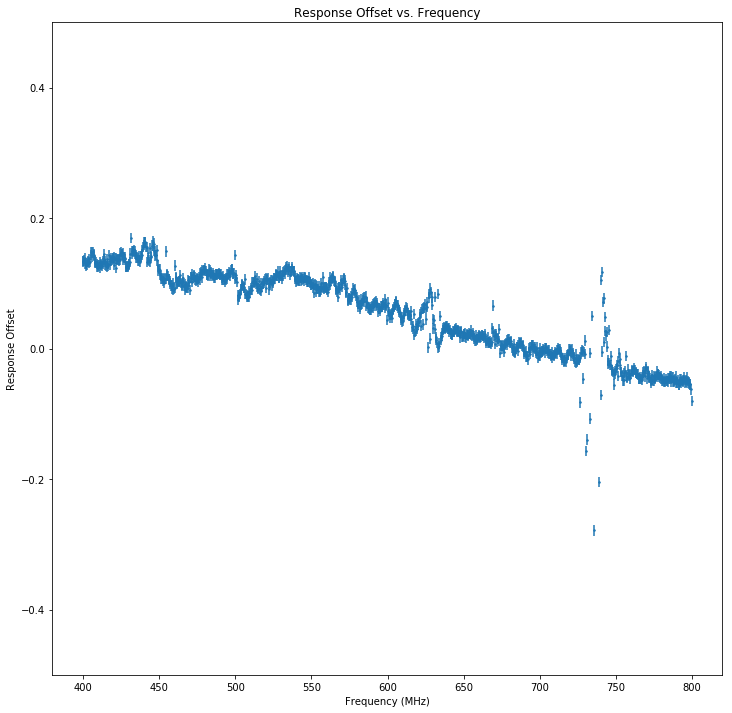

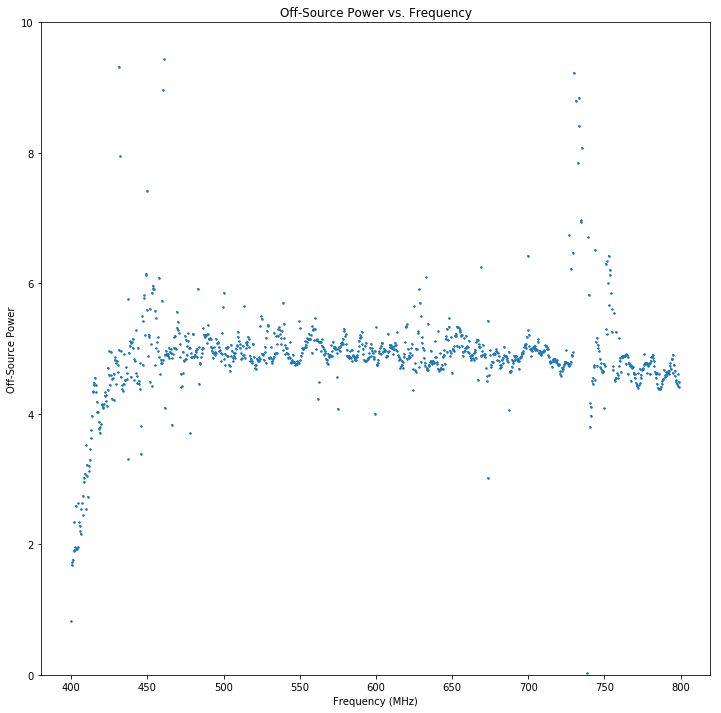

In [9]:
#Gaussian function
def Gaussian(x,*p):
    A, mu, sigma, base = p
    return A*np.exp(-(x-mu)**2/(2*sigma**2))+base

p0 = [20,0,1,5]
amplitude_array = np.zeros(nf)
sigma_array = np.zeros(nf)
mean_array = np.zeros(nf)
base_array = np.zeros(nf)
for i in range(0,1024):
    p_opt_all, p_cov_all = curve_fit(Gaussian, offset_array, StokesI_CasA_ARO[:,i], p0=p0) 
    amplitude_array[i] = p_opt_all[0]
    mean_array[i] = p_opt_all[1]
    sigma_array[i] = p_opt_all[2]
    base_array[i] = p_opt_all[3]

amplitude_err = np.sqrt(p_cov_all[0][0])
mean_err = np.sqrt(p_cov_all[1][1])
bw_err = 2.355*np.sqrt(p_cov_all[2][2])
base_err = np.sqrt(p_cov_all[1][1])

freq_axis = np.arange(400,800,(400/1024))

FWHM_exp = 2.355*sigma_array
plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, FWHM_exp, xerr=None, yerr=bw_err, ls='',marker='o',markersize=1.5)
plt.ylim(0.5,2)
plt.title('Beamwidth vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('FWHM')
#plt.savefig('FWHM.png')

plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, amplitude_array, xerr=None, yerr=amplitude_err, ls='', marker='o', markersize=1.5)
plt.ylim(-5,30)
plt.title('Response Amplitude vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Response')

plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, mean_array, xerr=None, yerr=mean_err, ls='', marker='o', markersize=1.5)
plt.ylim(-0.5,0.5)
plt.title('Response Offset vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Response Offset')

plt.figure(figsize=(12,12))
plt.errorbar(freq_axis, base_array, xerr=None, yerr=base_err, ls='', marker='o', markersize=1.5)
plt.ylim(0,10)
plt.title('Off-Source Power vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Off-Source Power')

Text(0.5,1,'Theoretical Beamwidth Curve')

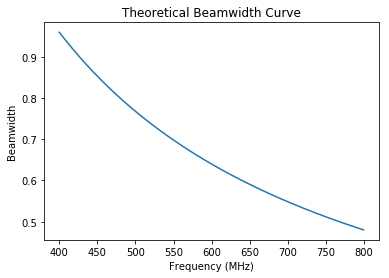

In [10]:
#Theoretical beamwidth
c = 3*(10**8) #speed of light
wavelength = np.zeros(len(lf_flipped))
for i in range(0, len(lf_flipped)):
    wavelength[i] = c/lf_flipped[i]
FWHM_theory = np.zeros(len(lf_flipped))
for i in range(0, len(wavelength)):
    FWHM_theory[i] = (1.028*wavelength[i]/46)*(180/np.pi) #convert from rad to degrees


freq_axis = np.arange(400,800,(400/1024))

plt.plot(freq_axis, FWHM_theory)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Beamwidth')
plt.title('Theoretical Beamwidth Curve')
#plt.savefig('theory_beam.png')

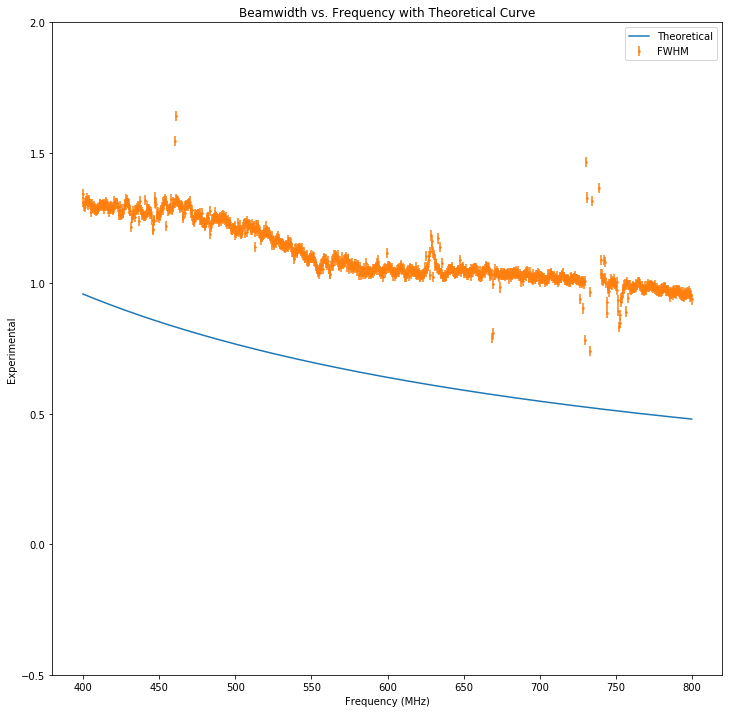

In [11]:
#Plot beamwidth against theoretical curve
plt.figure(figsize=(12,12))
plt.plot(freq_axis, FWHM_theory, label='Theoretical')
plt.errorbar(freq_axis, FWHM_exp, xerr=None, yerr=bw_err, ls='',marker='o',markersize=1.5, label='FWHM')
plt.ylim(-0.5,2)
plt.title('Beamwidth vs. Frequency with Theoretical Curve')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Experimental')
plt.legend()
#plt.savefig('FWHM_theory.png')

(-0.1, 2)

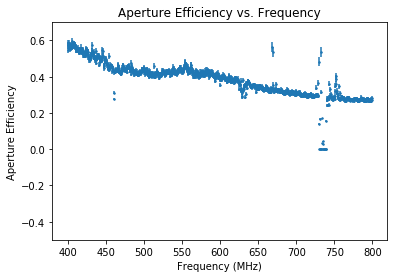

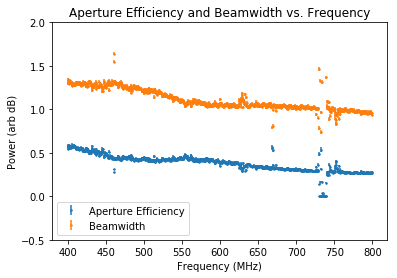

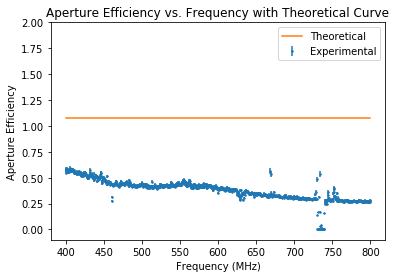

In [12]:
##Calculate aperture efficiency:
#Calculate solid angle
Omega = np.pi*(FWHM_exp*(np.pi/180))**2/(4*np.log(2))
Omega_err = ((np.pi*2*FWHM_exp*bw_err)*(np.pi/180)**2)/(4*np.log(2))

#Calculate collecting area 
Ae = wavelength**2/Omega 
Ae_err = (wavelength**2)*(Omega_err/(Omega**2))

#Calculate geometric area of the telescope
A_geom = np.pi*(22.9**2)

#Calculate aperture efficiency
eta = Ae/A_geom
eta_err = Ae_err/A_geom

#Plot aperture efficiency
plt.figure()
plt.errorbar(freq_axis, eta, xerr=None, yerr=eta_err, ls='', marker='o', markersize=1.5)
plt.title('Aperture Efficiency vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Aperture Efficiency')
plt.ylim(-0.5,0.7)
#plt.savefig('aperture_efficiency.pdf')

#Plot aperture efficiency and beamwidth
plt.figure()
plt.errorbar(freq_axis, eta, xerr=None, yerr=eta_err, ls='', marker='o', markersize=1.5, label='Aperture Efficiency')
plt.errorbar(freq_axis, FWHM_exp, xerr=None, yerr=bw_err, ls='', marker='o', markersize=1.5, label='Beamwidth')
plt.legend()
plt.ylim(-0.5,2)
plt.title('Aperture Efficiency and Beamwidth vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (arb dB)')

#Calculate theoretical aperture efficiency
Omega_theory = np.pi*(np.radians(FWHM_theory))**2/(4*np.log(2))
Ae_theory = wavelength**2/Omega_theory
eta_theory = Ae_theory/A_geom

#Plot aperture efficiency and theoretical aperture efficiency
plt.figure()
plt.errorbar(freq_axis, eta, xerr=None, yerr=eta_err, ls='', marker='o', markersize=1.5, label='Experimental')
plt.plot(freq_axis, eta_theory, label='Theoretical')
plt.legend()
plt.title('Aperture Efficiency vs. Frequency with Theoretical Curve')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Aperture Efficiency')
plt.ylim(-0.1,2)

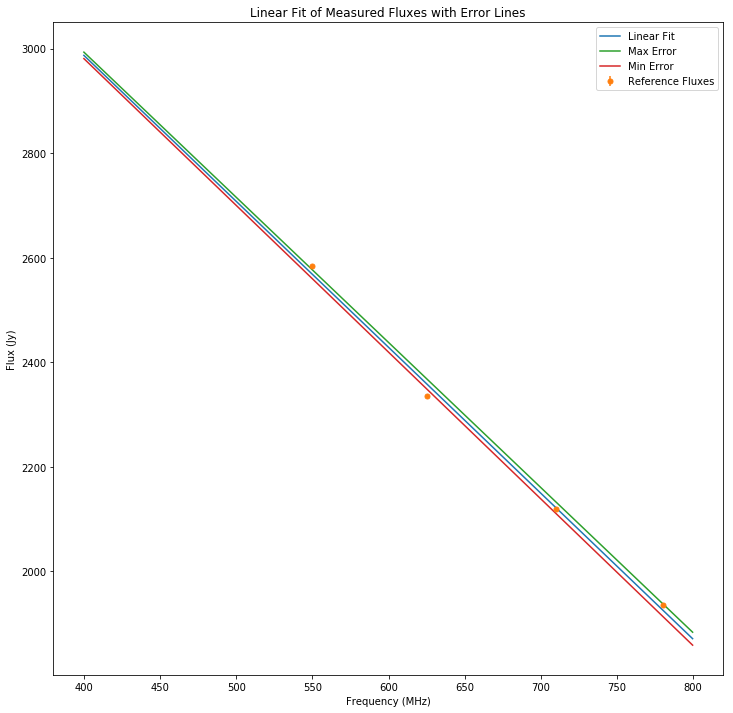

In [13]:
#Fluxes according to paper cited in lab manual: 
#550MHz = 5170Jy
#625MHz = 4670Jy
#710MHz = 4240Jy
#780MHz = 3870Jy
#Fluxes have dimmed roughly 50% in the last 40 years:
measured_freqs_Hz = np.array((550, 625, 710, 780))/1000000 
measured_freqs_MHz = np.array((550, 625, 710, 780))
measured_flux_1977_SI = np.array((5170, 4670, 4240, 3870))*10e-26 #Reference fluxes, convert from Jy to W/m^2Hz
measured_flux_1977_Jy = np.array((5170, 4670, 4240, 3870)) #Reference fluxes
measured_flux_now_SI = measured_flux_1977_SI*.5 #Divide by 2 because has dimmed 50%
measured_flux_now_Jy = measured_flux_1977_Jy*.5 #Divide by 2 because has dimmed 50%

#Define linear model function
def linear(x,b,m):
    y= m*x + b
    return y

#Define x-axis data
x_freq_data = np.arange(400,800, 400/len(measured_flux_now_Jy))

#Linear fit for reference fluxes
p_opt, p_cov = curve_fit(linear, measured_freqs_MHz, measured_flux_now_Jy, p0=(1,0))
p_opt_flux = p_opt
p_cov_flux = p_cov

#Plot reference fluxes with fit
#Define array for estimated reference fluxes around ARO band
estimated_ref_flux = linear(np.arange(400,800, 400/1024),*p_opt_flux) 
#where I have extended x-axis to cover whole frequency band (400-800MHz)
plt.figure(figsize=(12,12))
plt.plot(np.arange(400,800,400/1024), estimated_ref_flux, label='Linear Fit')
plt.errorbar(measured_freqs_MHz, measured_flux_now_Jy, yerr = p_cov_flux[1][1], ls='', marker='o', markersize=5, label='Reference Fluxes')
plt.plot(np.arange(400,800,400/1024), linear(np.arange(400,800,400/1024), p_opt_flux[0], 
                                             (p_opt_flux[1]+p_cov_flux[1][1])), label='Max Error')
plt.plot(np.arange(400,800,400/1024), linear(np.arange(400,800,400/1024), p_opt_flux[0], 
                                             (p_opt_flux[1]-p_cov_flux[1][1])), label='Min Error')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.title('Linear Fit of Measured Fluxes with Error Lines')
plt.legend()

[1163.81507608]
[61.67337645]


/Applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0,0.5,'Temperature (K)')

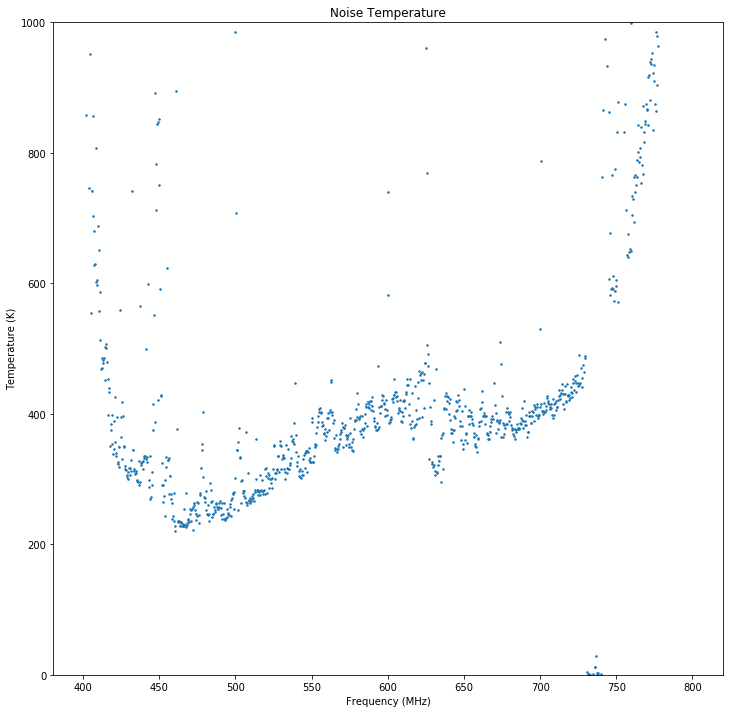

In [14]:
#Calculate the temperature corresponding to 625MHz:
wavelength_625 = 3e8/625e6
kB = 1.380648e-23

#Find the solid angle that corresponds to 625 MHz 
pos = np.where(lf[::-1] == 625e6)
Tangle = Omega[pos[0]]

#Define the effective aperture
Ae_625 = np.pi*(45.8/2)**2*eta[::-1][pos[0]]

#Now apply the equation to change temperature to the equation given to us in the lab manual
#This equation is rearranged using the known equation for power
T_625= measured_flux_now_Jy[1]*Ae_625/kB*1e-26
print(T_625)
T_625_err = measured_flux_now_Jy[1]*(T_625*(Ae_err[pos[0]]/Ae_625))/kB*1e-26
print(T_625_err)

#Define functions for initial conditions
#Function for gain
def p0(x,y,n):
    p0 = ((n*np.sum(x*y)) - (np.sum(x)*np.sum(y)))/((n*np.sum(x**2)) - ((np.sum(x))**2))
    return p0

#Function for system noise 
def p1(x,y,n,p):
    p1 = (1/n)*(np.sum(y) - p*np.sum(x))
    return p1

#Now calculating the temperature of CasA for all frequencies
A_all = np.pi*(45.8/2)**2*eta[::-1]
A_all_err = eta_err*np.pi*((48.5/2)**2)
T_all = estimated_ref_flux*A_all/kB*1e-26 
T_all_err = T_all*np.sqrt(((p_cov_flux[1][1]/estimated_ref_flux)**2 + (A_all_err/A_all/kB*1e-26)**2))
#Need to subract the power of the off source from the power of the source
powersource = StokesI_CasA_ARO[22]-StokesI_CasA_ARO[0]

p0_test = p0(T_all, powersource, 1024)
p1_test = p1(T_all, powersource,1024,p0_test)


#So now fit a line for every frequency
poptT = np.zeros((2,1024))
pcovT = np.zeros((2,2))
for i in np.arange(1024):    
    popT,covT, = curve_fit(linear, [10,T_all[::-1][i]], [StokesI_CasA_ARO[::][0,i], powersource[::][i]], p0 = (-0.009511083901105043,25.904513834402174))
    poptT[0,i] = popT[0]
    poptT[1,i] = popT[1]

plt.figure(figsize=(12,12))
plt.errorbar(lf_flipped/1e6, poptT[0]/poptT[1], xerr=None, yerr=T_all_err, ls ='', marker ='o', markersize=1.5)
plt.title('Noise Temperature')
plt.ylim(0,1000)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
#plt.savefig('noise_temp.png')

(0, 0.025)

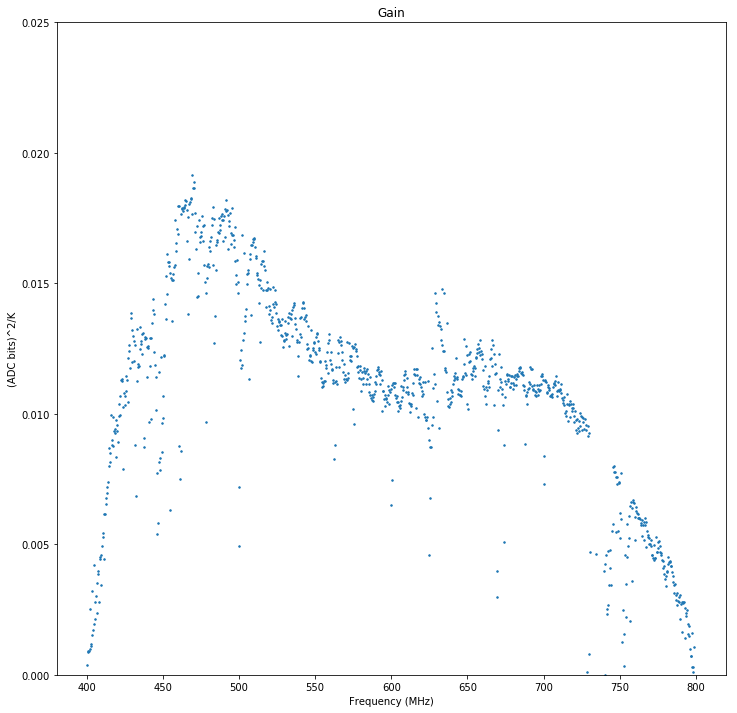

In [15]:
#Plot the gain
plt.figure(figsize=(12,12))
plt.errorbar(lf_flipped/1e6, poptT[1], ls='', marker='o', markersize=1.5)
plt.title('Gain')
plt.xlabel('Frequency (MHz)')
plt.ylabel('(ADC bits)^2/K')
plt.ylim(0,0.025)

In [16]:
#Pulsar header
pulsar_data = open("AST326_ARO_B0329+54.dat", "rb")
header_packed = pulsar_data.read(48)
header_unpacked = struct.unpack('=iiiidiiiId', header_packed)

slice_length = header_unpacked[0]
header_length = header_unpacked[1]
number_samples = header_unpacked[2]
data_type = header_unpacked[3]
cadence_raw = header_unpacked[4]
number_freqs = header_unpacked[5]
number_elems = header_unpacked[6]
spec_sum = header_unpacked[7]
handshake_index = header_unpacked[8]
handshake_utc = header_unpacked[9]

#Pulsar frequencies
header_info = pulsar_data.read(number_freqs*4*2)
freq_list = np.frombuffer(header_info[:number_freqs*4*2], dtype=np.float32)
freq_list = freq_list.reshape(-1,2)
freqs = freq_list.mean(axis=1)

#Import the data
data_list = []
azimuth = []
altitude = []
time_index = []
for i in np.arange(10000):
    data_header = np.frombuffer(pulsar_data.read(header_length), dtype=np.float32)
    index, az, alt = struct.unpack('Iff', data_header)
    data = np.frombuffer(pulsar_data.read(slice_length-header_length),dtype=np.float32) 
    data_list.append(data)
    azimuth.append(az)
    altitude.append(alt)
    time_index.append(index)
data_array = np.array(data_list)

#Define time data
timestep = cadence_raw*spec_sum
t = timestep*np.arange(data_array.shape[0]) 
print(t)

[0.00000000e+00 6.55360000e-04 1.31072000e-03 ... 6.55163392e+00
 6.55228928e+00 6.55294464e+00]


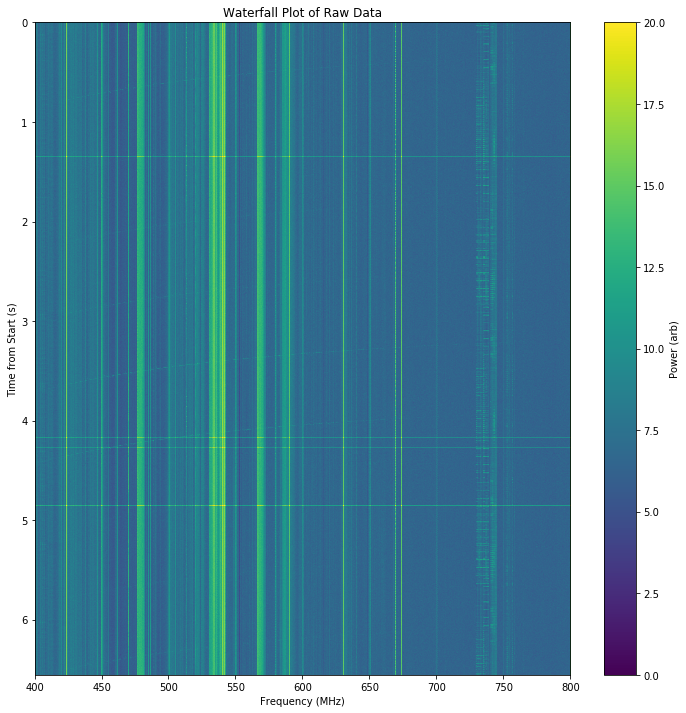

In [17]:
#Waterfall plot of raw data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(data_array),aspect="auto", extent=[400,800,np.amax(t), np.amin(t)], vmax=20, vmin=0)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Raw Data')
plt.colorbar().set_label('Power (arb)', rotation=90)

[[ 19554.43155525  12756.53512874  10487.48996615 ... -92920.63888799
  -63991.01399602  -3174.91766668]
 [ 20084.38276394  12850.71525061  11158.4385021  ... -91629.51407495
  -60838.74729671  -3162.06653626]
 [ 20967.63477841  11801.74354833  11412.39565823 ... -88563.092644
  -66025.65886557  -3167.80364805]
 ...
 [ 19178.08939256  11451.00378409  10885.66970477 ... -92718.90063595
  -69206.58253488  -3169.63952383]
 [ 20814.02573242  13133.25561624  11509.58913774 ... -88724.48324563
  -65137.29279577  -3166.88571017]
 [ 18709.58180228  13730.8122516   11390.4487435  ... -87796.48728626
  -67917.01888516  -3196.25972255]]
[ 18701.90134998  11632.86884703  10697.55329282 ... -97157.14218075
 -68404.18737505  -3153.34612633]


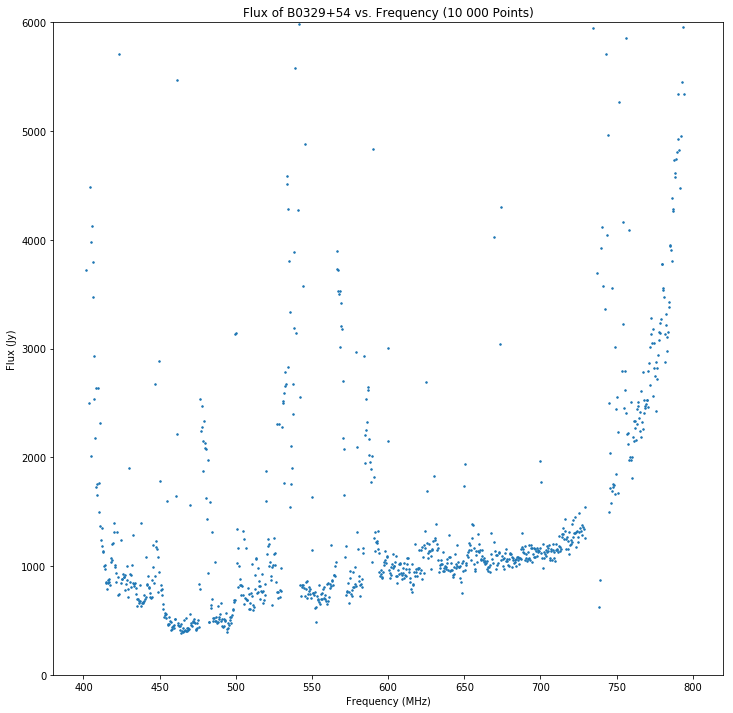

In [18]:
#Calculate flux of pulsar in Jy using gain from Cas A
power_by_gain = data_array/poptT[1] #Dividing Stokes I data by the gain to put it into Kelvin

#Convert to flux in SI units
pulsar_flux_SI = (power_by_gain*kB)/Ae

#Convert to flux in Jy
pulsar_flux_Jy = pulsar_flux_SI*1e26
print(pulsar_flux_Jy)

#Choose representative sub-band (middle one)
print(pulsar_flux_Jy[5000])

#Plot representative flux
plt.figure(figsize=(12,12))
plt.plot(freqs, pulsar_flux_Jy[5000], ls='', marker='o', markersize=1.5)
plt.title('Flux of B0329+54 vs. Frequency (10 000 Points)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.ylim(0,6000)
plt.savefig('pulsar_flux_10000.pdf')

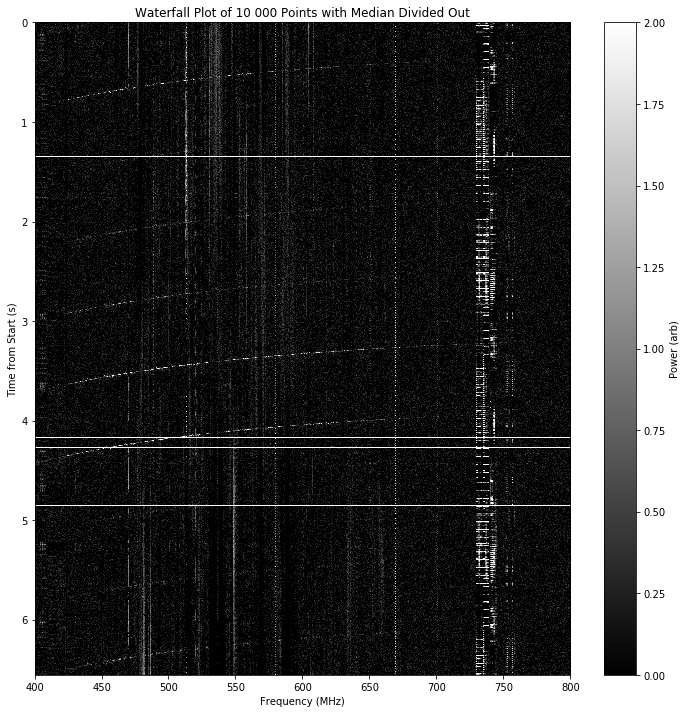

In [19]:
#Divide out median to reduce noise
median_RFI = np.median(data_array, axis=0) #Calculate median
RFI_less = data_array/median_RFI #Divide by median

#Plot data with median divided out
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(RFI_less), extent=[400,800,np.amax(t), np.amin(t)], aspect='auto', vmax=2, vmin=0, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of 10 000 Points with Median Divided Out')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_clean_10000.pdf')

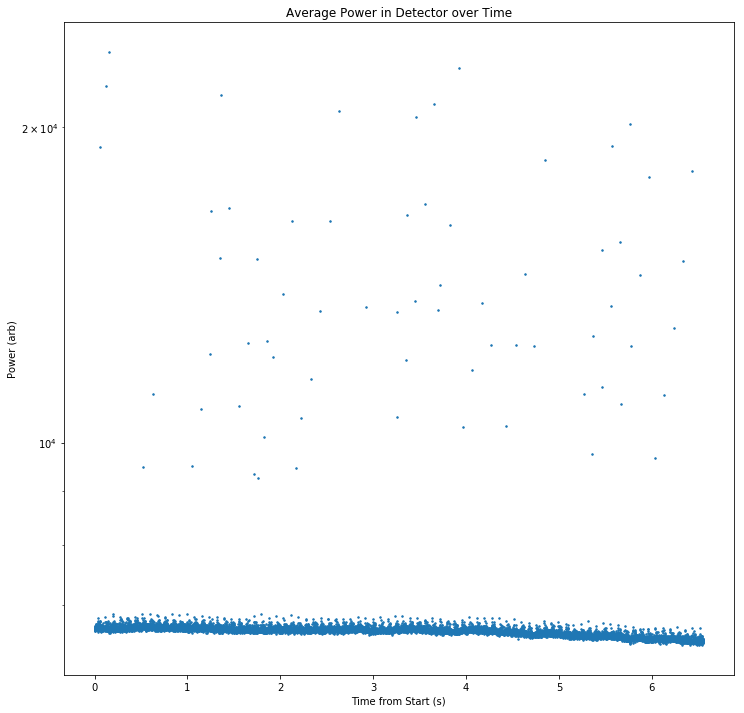

In [20]:
#Cut out RFI
data_sum = np.sum(data_array, axis=1) #Sum data over the frequencies

#Plot this to see where the RFI is
plt.figure(figsize=(12,12))
plt.plot(t, data_sum, ls='', marker = 'o', markersize = 1.5)
plt.semilogy()
plt.xlabel('Time from Start (s)')
plt.ylabel('Power (arb)')
plt.title('Average Power in Detector over Time')
plt.savefig('RFI_find_10000.pdf')

#Define where the RFI is
large_values = np.where(data_sum > 7820)
period = 0.714519699726 #period
sample_period = period/timestep #how many samples in a period, dt is time per sample 
number_pulses_exp = int(10000/sample_period) #how many pulses you expect to have (can count these in plot, should be about 9)

In [21]:
#Fold the data
freq_number = 1024
pixel_bins = 500 #Define bins for resolution
folded_pulses = np.zeros((pixel_bins, freq_number)) #Create array for folded pulses
pulse_in_phase = np.zeros((pixel_bins, freq_number)) #Create array for number of pulses folding over

#Cut RFI out of the data
RFI_noise = large_values[0].tolist() 
RFI_noise.append([0])
for i in np.arange(data_array.shape[0]):
    if i == RFI_noise[0]: 
        RFI_noise.pop(0) #Pop out RFI
        continue #Continue through array until reach next RFI point
    #Define phase of pulses
    phase = np.int(pixel_bins*np.modf(i*timestep/period)[0])
    folded_pulses[phase,:] += data_array[i,:] #Summing over the power to fold
    pulse_in_phase[phase,:] += 1 #How many pulses summing over 

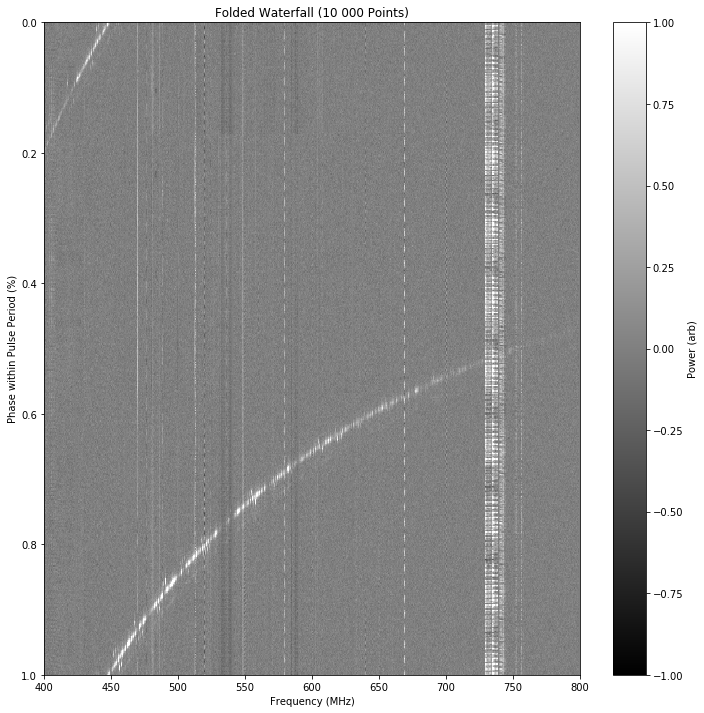

In [22]:
#Check the fold
fold_avg = folded_pulses/pulse_in_phase 
folded_data = fold_avg/median_RFI #Divide out median to reduce noise

#Plot folded data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(folded_data), extent=[400,800,1, 0], aspect='auto', vmax=1, vmin=-1, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (%)')
plt.title('Folded Waterfall (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_folded_10000.pdf')

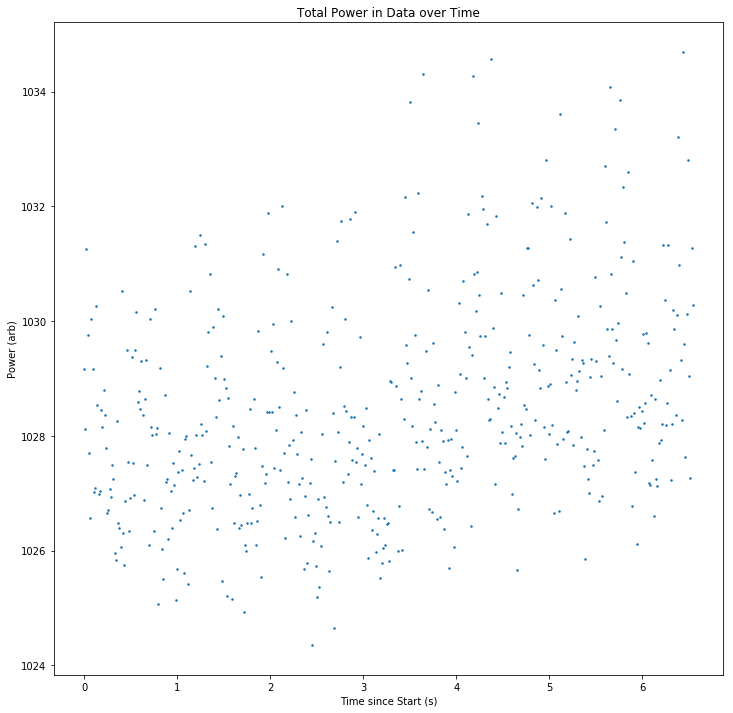

In [23]:
#Clean up fold
fold_sum = np.sum(folded_data, axis=1) #Sum over the frequency axis

#Plot to see where the RFI is (there isn't really any)
plt.figure(figsize=(12,12))
plt.plot(np.arange(np.amin(t), np.amax(t), (np.amax(t) - np.amin(t))/500), fold_sum, ls='', marker='o', markersize=1.5)
plt.title('Total Power in Data over Time')
plt.xlabel('Time since Start (s)')
plt.ylabel('Power (arb)')
plt.savefig('RFI2_10000.pdf')

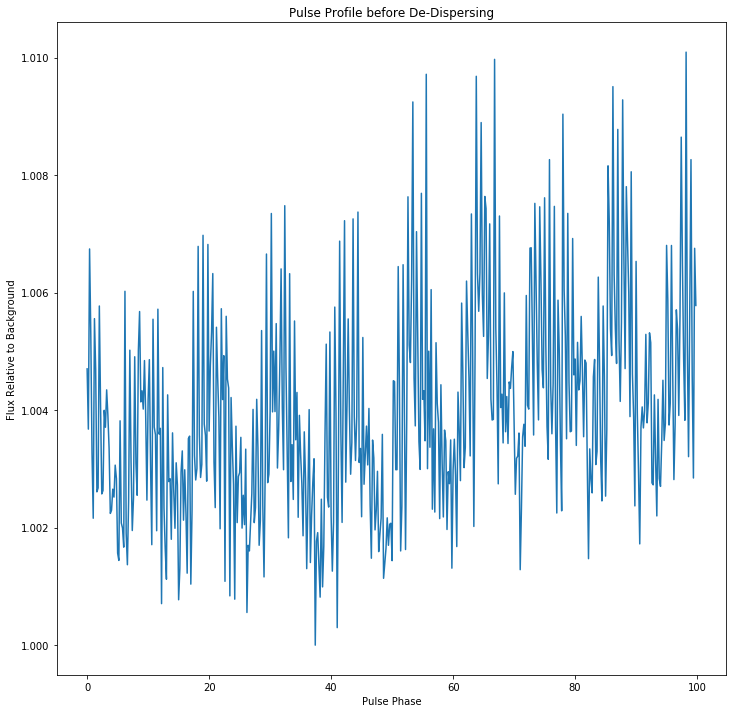

In [24]:
#Calculate profile before de-dispersing
profile_dispersed = np.sum(folded_data, axis=1)
#Normalize
normal_profile_dispersed = profile_dispersed/np.min(profile_dispersed)

#Plot profile before de-dispersing
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/500),normal_profile_dispersed)
plt.title('Pulse Profile before De-Dispersing')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
plt.savefig('pulse_profile_dispersed_10000.pdf')

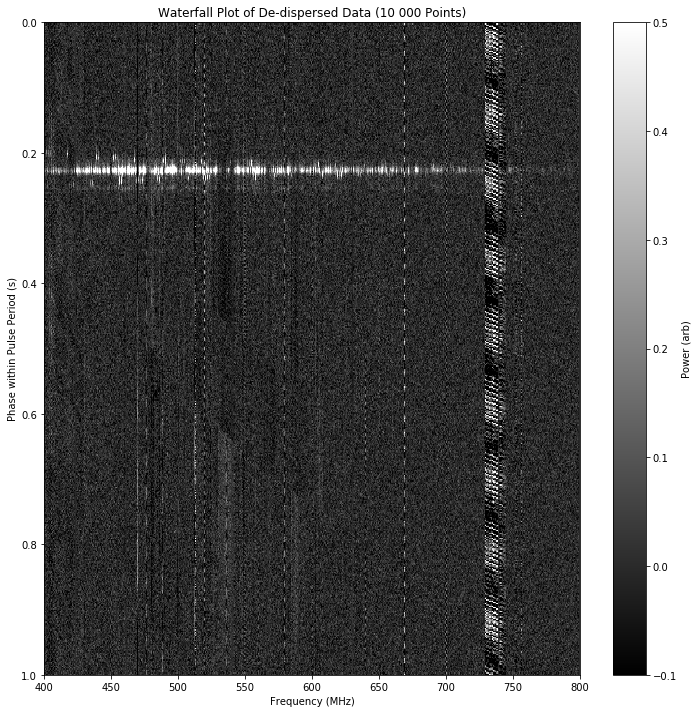

In [25]:
#De-disperse
k = 4.15e-3 #Dispersion measure time prefactor
dm = 26.7641 #Dispersion measure
dispersion = (k*dm*(freqs/1000)**-2) #Calculate dispersion 
dm_array = np.zeros((500,1024)) #Create array to put de-dispersed data into
for i in np.arange(freq_number): #Iterate through number of frequencies
    dm_array[:,i] = np.roll(folded_data[:,i], -int(dispersion[i]/period*pixel_bins)) #Roll over the period to de-disperse

#Divide by median to reduce noise
dedispersed_data = dm_array/np.median(dm_array, axis=0)

plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_data), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', \
           vmin = -.1, vmax = .5, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_de_dispersed_10000.pdf')

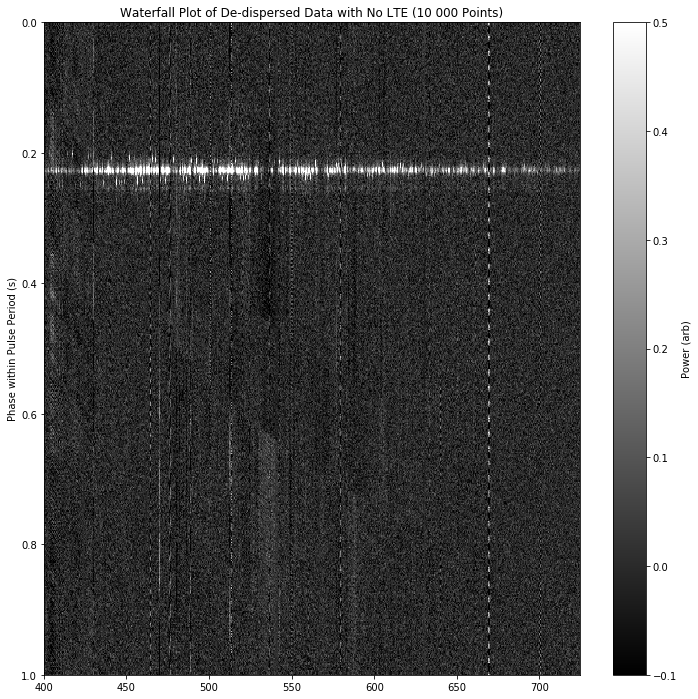

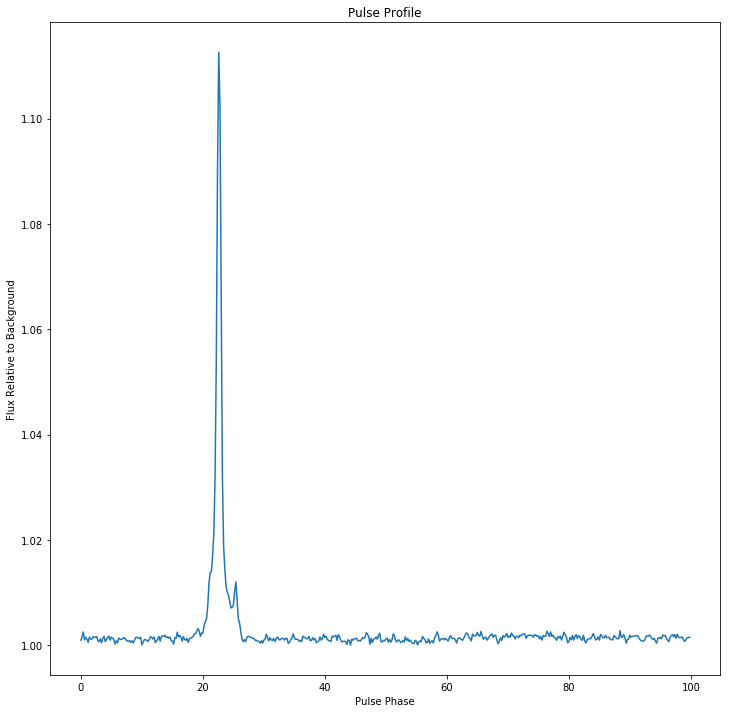

In [26]:
#Cut out LTE band
LTE_less = []
temp_list = []
for i in np.arange(0,500):
    temp_list = list(dedispersed_data[i][0:830])
    LTE_less.extend(temp_list)
LTE_less_array = np.array(LTE_less)
LTE_reshaped = LTE_less_array.reshape(500,830)

#Plot LTE-less data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_reshaped), extent = [np.amin(freqs), 724.41406, 1, 0], aspect = 'auto', vmin = -.1, \
           vmax = .5, cmap='gray')
plt.title('De-dispersed Data with LTE Band Excised')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data with No LTE (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_dedispersed_noLTE_10000.pdf')

#Sum over frequency axis to create pulse profile
profile = np.sum(LTE_reshaped, axis=1)
#Normalize
normal_profile = profile/np.min(profile)

#Plot normal pulse profile
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/500),normal_profile)
plt.title('Pulse Profile')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
plt.savefig('pulse_profile_10000.pdf')

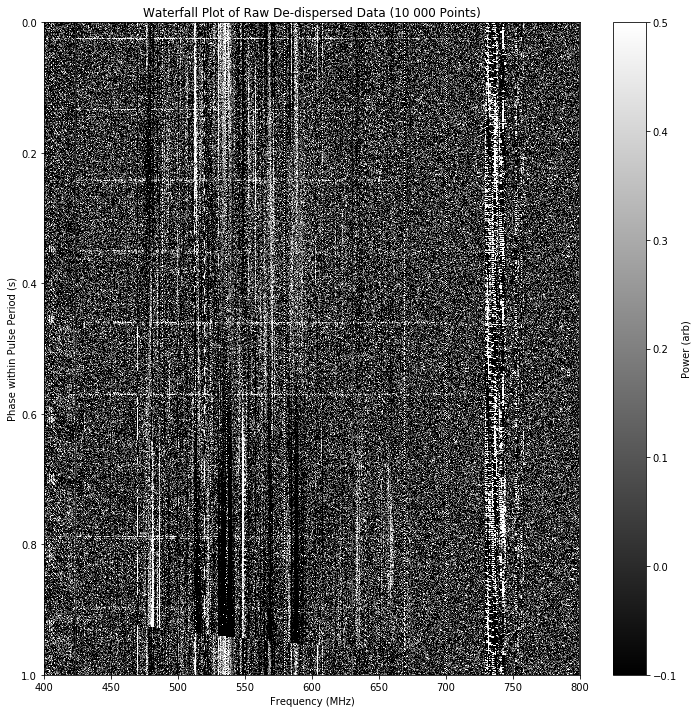

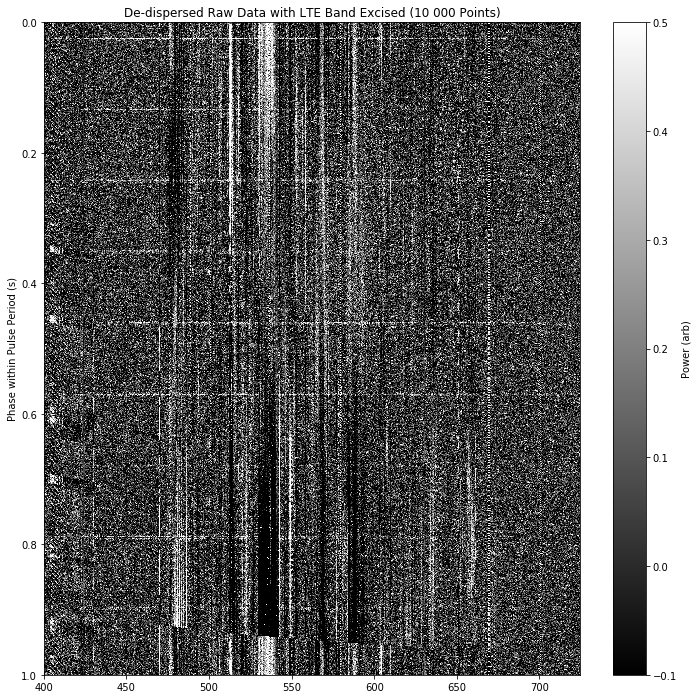

In [27]:
#De-disperse raw dataset 
k = 4.15e-3 #Dispersion measure time prefactor
dm = 26.7641 #Dispersion measure
dispersion = (k*dm*(freqs/1000)**-2) #Calculate dispersion
dm_array_raw = np.zeros((10000,1024)) #Create array for de-dispersed data
for i in np.arange(freq_number): #Iterate through number of frequencies
    dm_array_raw[:,i] = np.roll(RFI_less[:,i], -int(dispersion[i]/timestep)) #Roll in time to de-disperse

#Divide by the median to reduce noise
dedispersed_raw = dm_array_raw/np.median(dm_array_raw, axis=0)

#Plot the de-dispersed raw data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_raw), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', \
           vmin = -.1, vmax = .5, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of Raw De-dispersed Data (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('raw_dedispersed_10000.pdf')

#Remove LTE as above
LTE_less_raw = []
temp_list_raw = []
for i in np.arange(0,10000):
    temp_list_raw = list(dedispersed_raw[i][0:830])
    LTE_less_raw.extend(temp_list_raw)
LTE_raw_array = np.array(LTE_less_raw)
LTE_raw_reshaped = LTE_raw_array.reshape(10000,830)

#Plot LTE-less de-dispersed raw data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_raw_reshaped), extent = [np.amin(freqs), 724.41406, 1, 0], aspect = 'auto', vmin = -.1, \
           vmax = .5, cmap='gray')
plt.title('De-dispersed Raw Data with LTE Band Excised (10 000 Points)')
plt.ylabel('Phase within Pulse Period (s)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('dedispersed_raw_noLTE_10000.pdf')

In [40]:
#How pulse amplitudes vary in time
amplitude_data = np.sum(LTE_raw_reshaped, axis=1) #Sum over the frequency axis
normal_amplitude = amplitude_data/np.min(amplitude_data) #Normalize the data
#Calculate the median as well, will result in less noise
amplitude_median = np.median(LTE_raw_reshaped, axis=1)

print(normal_amplitude.shape)
print(poptT[1].shape)

#Rebin timeseries data for convolution
#phase_bins = 10000/1024 #Divide the period by the number of bins
#timeseries_bins = phase_bins/timestep #Divide the phase bins by the timestep
#print(timeseries_bins)
#amplitude_reshaped = normal_amplitude.reshape(-1,1) #Reshape the amplitude data accordingly
#amplitude_rebinned = np.mean(amplitude_reshaped, axis=1) #Take the mean

#Rebin timeseries data
flux_bins = 10000/830 #Divide the period by the number of bins in the average pulse profile  
#Create bins for the timeseries
print(flux_bins)
amplitude_reshaped_flux = normal_amplitude.reshape(-1,13) #Reshape the amplitude data accordingly
amplitude_rebinned_flux = np.mean(amplitude_reshaped_flux, axis=1) #Take the mean
print(amplitude_rebinned_flux.shape)

#normal_amplitude_Jy = (((amplitude_rebinned_flux/poptT[1][0:830])*kB)/Ae)*1e26

(10000,)
(1024,)
12.048192771084338


ValueError: cannot reshape array of size 10000 into shape (13)

In [19]:
#Extra stuff
period_der = 2.048265e-15
period = 0.714519699726

#Calculate characteristic age
def char_age(p, pdot):
    tau = p/(2*pdot)
    return tau

char_age_pulsar = char_age(period, period_der) #Characteristic age in seconds
char_age_pulsar_yr = char_age_pulsar/31536000
print("The characteristic age of the pulsar is", char_age_pulsar_yr, "years. \
This is consistent with the known value of the age of the pulsar.")

#Calculate characteristic magnetic field
def char_Bfield(p, pdot):
    B_gauss = 3.2e19*np.sqrt(p*pdot)
    return B_gauss

char_Bfield_pulsar = char_Bfield(period, period_der)
print("The characteristic magnetic field of the pulsar is greater than", char_Bfield_pulsar, "gauss. \
This is consistent with the known value of the magnetic field of the pulsar.")

The characteristic age of the pulsar is 5530844.653063299 years. This is consistent with the known value of the age of the pulsar.
The characteristic magnetic field of the pulsar is greater than 1224193738501.1812 gauss. This is consistent with the known value of the magnetic field of the pulsar.


In [20]:
#Pointing of telescope for pulsar
alt_array_pulsar = np.array(altitude)
az_array_pulsar = np.array(azimuth)
alt_az_pulsar = np.stack((alt_array_pulsar, az_array_pulsar))
pulsar_coord_altaz = alt_az_pulsar.T
print(pulsar_coord_altaz)

[[55.08985138 68.90758514]
 [55.08985138 68.90758514]
 [55.08985138 68.90758514]
 ...
 [55.08127975 68.92318726]
 [55.08127975 68.92318726]
 [55.08127594 68.92318726]]
